In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

import os
import numpy as np
from matplotlib.pyplot import gcf
import pandas as pd 
import sys
#import pickle
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random
from sklearn.metrics import pairwise_distances
from sklearn.kernel_ridge import KernelRidge
import math
import dill as pickle
import matplotlib as mpl
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
import allensdk.core.json_utilities as ju
workingdirectory = os.popen('git rev-parse --show-toplevel').read()[:-1]
sys.path.append(workingdirectory)
os.chdir(workingdirectory)

from mcmodels.core import VoxelModelCache
from mcmodels.utils import truncate_colormap, fix_pdcsv, fill_df_na

import matplotlib.pyplot as plt
import matplotlib.colors as colors

mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}'] #for \text command


reo = [4,7,2,1,10,9,11,3,5,8,6,0]


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/Users/samsonkoelle/miniconda3/envs/mcm_class/lib/python3.7/site-packages/ipykernel_launcher.py:36: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.


In [3]:
#read data
TOP_DIR = workingdirectory
INPUT_JSON = workingdirectory + '/data/meta/input_011520.json'
EXPERIMENTS_EXCLUDE_JSON = workingdirectory + '/data/meta/experiments_exclude.json'
input_data = ju.read(INPUT_JSON)
experiments_exclude = ju.read(EXPERIMENTS_EXCLUDE_JSON)
manifest_file = input_data.get('manifest_file')
manifest_file = os.path.join(TOP_DIR, manifest_file)
cache = VoxelModelCache(manifest_file=manifest_file)
st = cache.get_structure_tree()
ai_map = st.get_id_acronym_map()
ia_map = {value: key for key, value in ai_map.items()}
major_structures = np.load(workingdirectory + '/data/meta/major_structures.npy')
major_structure_ids = np.load(workingdirectory + '/data/meta/major_structure_ids.npy')
data_info = pd.read_excel(workingdirectory + '/data/meta/Whole Brain Cre Image Series_curation only.xlsx', 'all datasets curated_070919pull')
data_info.set_index("id", inplace=True)
with open('data/meta/leafs.pickle', 'rb') as handle:
    leafs = pickle.load(handle)
ontological_order_leaves = np.load(workingdirectory + '/data/meta/ontological_order_leaves_v3.npy')
COARSE_STRUCTURE_SET_ID = 2
DEFAULT_STRUCTURE_SET_IDS = tuple([COARSE_STRUCTURE_SET_ID])
tree = cache.get_structure_tree()
default_structures = tree.get_structures_by_set_id(DEFAULT_STRUCTURE_SET_IDS)
default_structure_ids = [st['id'] for st in default_structures if st['id'] != 934]
folder =  '/Users/samsonkoelle/mouse_connectivity_models/data/raw/'

annotation/ccf_2017


In [4]:
cmap = plt.get_cmap('Greys')
new_cmap = truncate_colormap(cmap, 0.1,1.)

In [5]:
wt_conn_file =  f"{workingdirectory}/paper/connectivities/revision_thresholded/el_leafsurf_leafsmth_leafleaf_C57BL6J_080222.csv"

wt_conn = pd.read_csv(wt_conn_file,   header=[0, 1])
wt_conn = fix_pdcsv(wt_conn)

nonzero_ind = np.where(np.sum(wt_conn, axis = 1) > 0)[0]
wt_conn_nonzero = wt_conn.iloc[nonzero_ind]
wt_conn_nonzero_log = np.log10(wt_conn_nonzero)
lowlim = -6
wt_conn_nonzero_log[wt_conn_nonzero_log < lowlim] = lowlim
ool_ic_majors = np.load('data/meta/ool_ic_majors_names_v3_0610.npy')
ool_i_majors = np.load('data/meta/ool_i_majors_names_v3_0610.npy')
ool_ic_majors = np.asarray([ia_map[ool_ic_majors[i ]] for i in range(len(ool_ic_majors))])
ool_i_majors = np.asarray([ia_map[ool_i_majors[i ]] for i in range(len(ool_i_majors))])

In [6]:
wt_conn.columns.names = np.asarray(['Hemisphere', 'Structure'])
hemi_labels = wt_conn.columns.get_level_values("Hemisphere")
hemi_pal = sns.color_palette("cubehelix", n_colors = hemi_labels.unique().size)
hemi_lut = dict(zip(map(str, hemi_labels.unique()), hemi_pal))
hemi_colors = pd.Series(hemi_labels, index=wt_conn.columns).map(hemi_lut)

targ_str_labels = ool_ic_majors#wt_conn.columns.get_level_values("Structure")
targ_str_pal = sns.color_palette("tab20", n_colors = np.unique(targ_str_labels).size)
targ_str_lut = dict(zip(map(str, np.unique(targ_str_labels)), targ_str_pal))
targ_str_colors = pd.Series(targ_str_labels, index=wt_conn.columns).map(targ_str_lut)

source_str_labels = ool_i_majors
source_str_pal = sns.color_palette("tab20", n_colors = np.unique(source_str_labels).size)
source_str_lut = dict(zip(map(str, np.unique(source_str_labels)), source_str_pal))
source_str_colors = pd.Series(source_str_labels, index=wt_conn.index).map(source_str_lut)

arr_targ = np.zeros((1123,2), dtype = object)
arr_targ[:,0] = hemi_colors
arr_targ[:,1] = targ_str_colors
combined_colors_targ = pd.DataFrame(arr_targ, index = wt_conn.columns)

arr_source = np.zeros((564,1), dtype = object)
arr_source[:,0] = source_str_colors
combined_colors_source = pd.DataFrame(arr_source, index = wt_conn.index)


combined_colors_targ.columns = np.asarray(['Hemisphere','Major Structure'])
combined_colors_source.columns = np.asarray(['Major Structure'])

strs_unique = np.unique(ool_ic_majors)
nstr = len(strs_unique)
cs = sns.color_palette("tab20", nstr)

color_str = {}
for i in range(nstr):
    color_str[strs_unique[i]] = cs[i]
  
cs_hemi = sns.color_palette("cubehelix", 2)

color_hemi = {}
hemis = np.asarray(['Ipsi','Contra'])
for i in range(2):
    #print(i)
    color_hemi[hemis[i]] = cs_hemi[i]

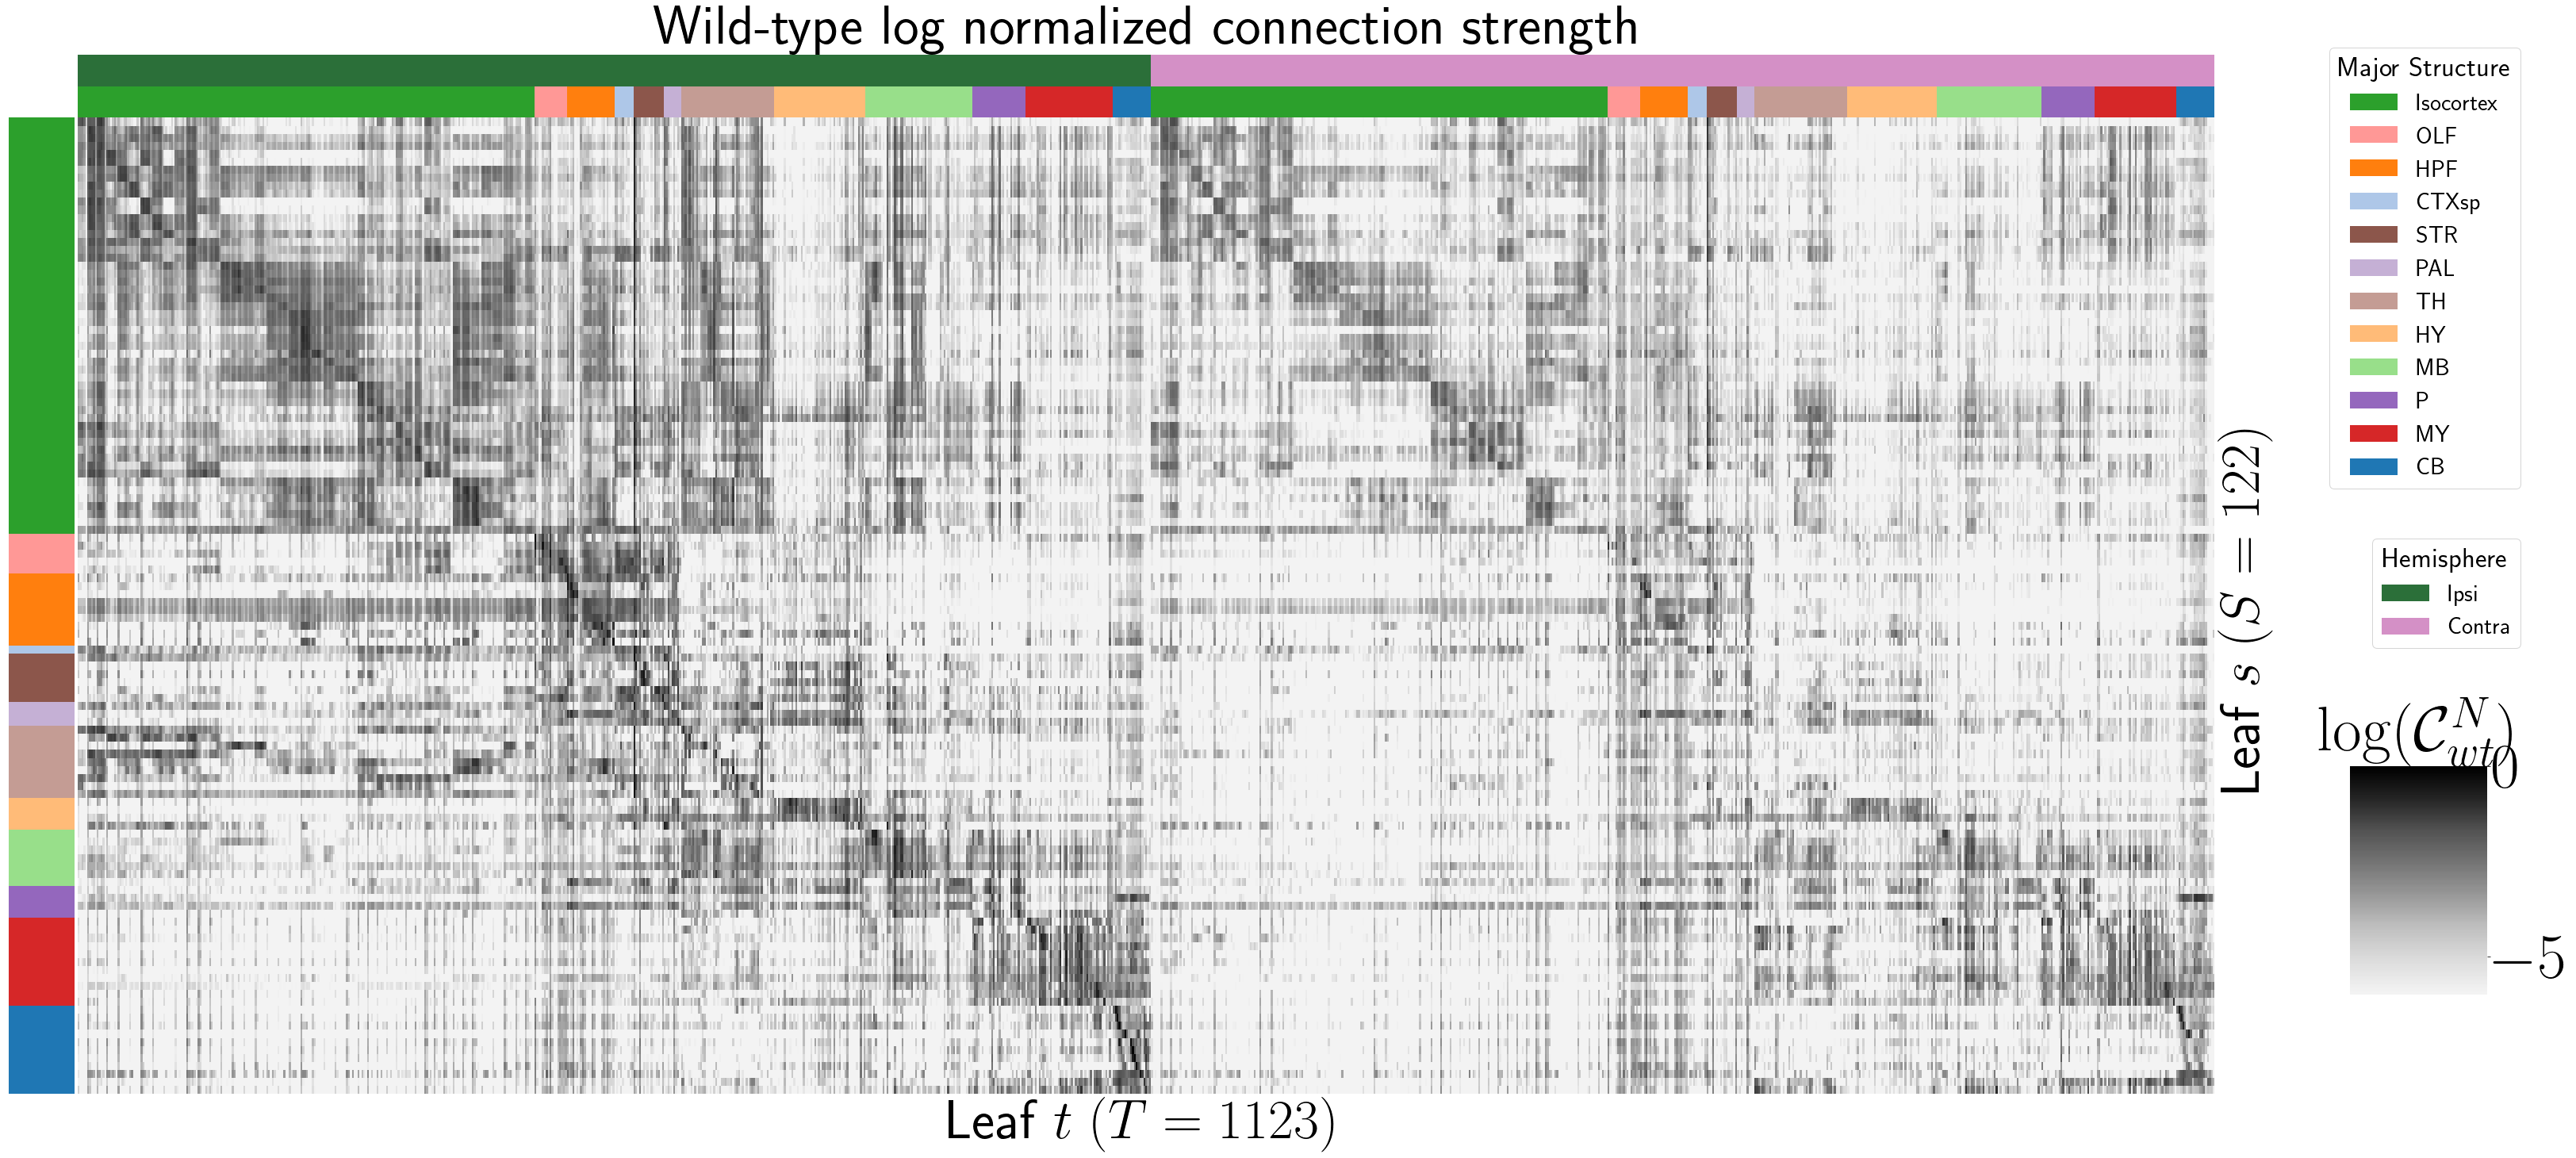

In [7]:
g= sns.clustermap(wt_conn_nonzero_log, col_cluster = False, row_cluster = False, col_colors=combined_colors_targ, 
                  row_colors = combined_colors_source, figsize = (40,20), cmap = new_cmap, vmin = -6, vmax = 0.,
                 dendrogram_ratio=(0,0.01),cbar_kws={"ticks":[-5,0]}, cbar_pos = [1.03,0.16,.06,.2])

g.ax_heatmap.set_xticks([])
g.ax_heatmap.set_yticks([])
g.ax_heatmap.set_yticklabels([])
g.ax_heatmap.set_xticklabels([])
g.ax_col_colors.set_yticks([])
g.ax_row_colors.set_xticks([])
g.ax_heatmap.set_xticks([])
g.ax_heatmap.set_yticks([])
g.ax_heatmap.set_yticklabels([])
g.ax_heatmap.set_xticklabels([])

g.ax_heatmap.set_xlabel('Leaf ' + r"$t \; (T = 1123)$", fontsize = 70)
g.ax_heatmap.set_ylabel('Leaf ' + r"$s \; (S = 122)$", fontsize = 70)

ax = gcf().add_axes((0.55,1.,0.,0.))
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
for label in np.asarray(major_structures)[reo]:
    ax.bar(0, 0, color=color_str[label], label=label, linewidth=0.)
l4 = ax.legend(title='Major Structure', ncol=1, bbox_to_anchor=(1.11, 1.), bbox_transform=gcf().transFigure, fontsize = 30,title_fontsize=35)    

ax2 = gcf().add_axes((0.55,.5,0.,0.))
ax2.xaxis.set_visible(False)
ax2.yaxis.set_visible(False)
for label in hemis:
    ax2.bar(0, 0, color=color_hemi[label], label=label, linewidth=0.)
l4 = ax2.legend(title='Hemisphere', ncol=1, bbox_to_anchor=(1.11, .57), bbox_transform=gcf().transFigure, fontsize = 30,title_fontsize=35)    
g.ax_cbar.set_title(r"$\log (\mathcal C_{wt}^N)$", rotation=0, fontsize = 80)
g.ax_cbar.set_yticklabels(g.ax_cbar.get_yticklabels(), fontsize=80)

g.ax_col_colors.set_title('Wild-type log normalized connection strength', fontsize = 70)

plt.margins(x=0,y=0)
# g.savefig('paper/KoelleConn_revision/figs/conn_leaf2.png', bbox_inches = 'tight',pad_inches = 0)

In [13]:
sumsum = pd.read_csv(f"{workingdirectory}/paper/connectivities/el_leafsurf_leafsmth_leafleaf_C57BL6J0428_log6_sumsum.csv", header = [0,1])
sumsum = fix_pdcsv(sumsum)
targ_sum_major_names = np.load(f'{workingdirectory}/data/meta/targ_sum_major_names.npy')
sumsum = np.log10(sumsum.iloc[:43, :43])
lowlim = -6
sumsum[sumsum < lowlim] = lowlim

Text(0.5, 1.0, '$\\log (\\mathcal C_{wt}^N)$')

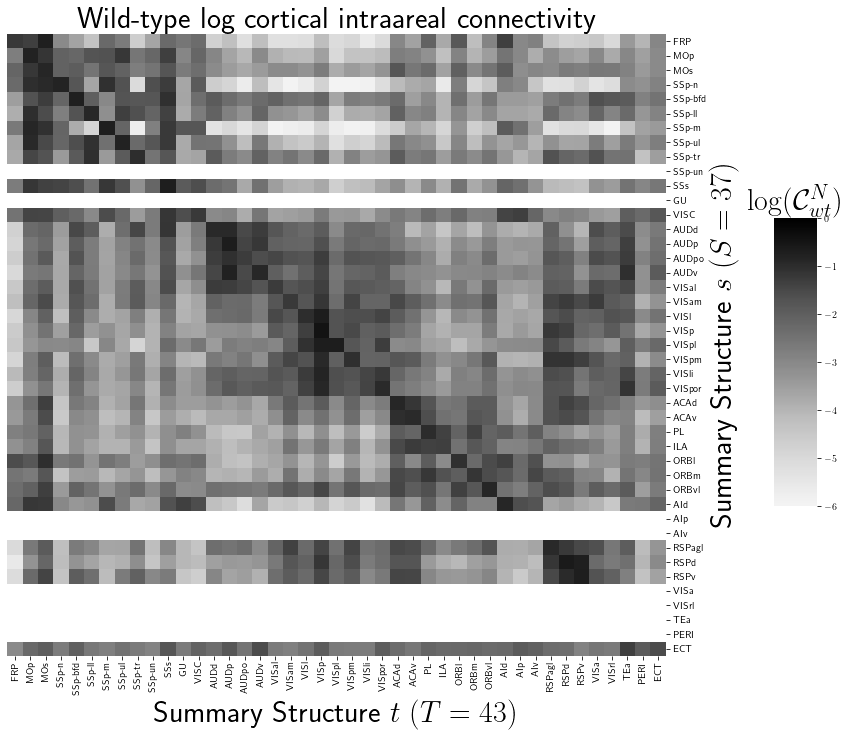

In [14]:
g=sns.clustermap(sumsum,
               vmin = -6,
               vmax=  0,
              col_cluster = False, 
               row_cluster = False,
              cmap = new_cmap,
                cbar_pos = [1.08,0.32,.06,.4],
                dendrogram_ratio=(0,0.01))

g.ax_heatmap.set_xticks(np.asarray(list(range(len(sumsum.columns)))) + 0.5 )
g.ax_heatmap.set_yticks(np.asarray(list(range(len(sumsum.columns)))) + 0.5)
g.ax_heatmap.set_yticklabels(sumsum.index)
g.ax_heatmap.set_xticklabels(sumsum.index)
g.ax_heatmap.set_xlabel('Summary Structure ' + r"$t \; (T = 43)$", fontsize = 30)
g.ax_heatmap.set_ylabel('Summary Structure ' + r"$s \; (S = 37)$", fontsize = 30)
g.ax_heatmap.set_title("Wild-type log cortical intraareal connectivity", fontsize = 30)
plt.margins(x=0,y=0)
g.ax_cbar.set_title(r"$\log (\mathcal C_{wt}^N)$", rotation=0, fontsize = 30)

# g.savefig('paper/KoelleConn_fromlocal_0623/figs/conn_sum_cortex.png', bbox_inches = 'tight',pad_inches = 0)
